### 1. Doodle Scheduling

In [23]:
using JuMP, Clp, NamedArrays

availability =
  [ 0 0 1 1 0 0 0 1 1 0 0 0 0
    0 1 1 0 0 0 0 0 1 1 0 0 0
    0 0 0 1 1 0 1 1 0 1 1 1 1
    0 0 0 1 1 1 1 1 1 1 1 1 0
    0 0 0 0 0 0 1 1 1 0 0 0 0
    0 1 1 0 0 0 0 0 1 1 0 0 0
    0 0 0 1 1 1 1 0 0 0 0 0 0
    1 1 0 0 0 0 0 0 0 0 1 1 1
    1 1 1 0 0 0 0 0 0 1 1 0 0
    0 0 0 0 0 0 0 1 1 0 0 0 0
    0 0 0 0 0 0 1 1 1 0 0 0 0
    1 1 0 0 0 1 1 1 1 0 0 1 1
    1 1 1 0 1 1 0 0 0 0 0 1 1
    0 1 1 1 0 0 0 0 0 0 0 0 0
    1 1 0 0 1 1 0 0 0 0 0 0 0 ]

TIMES = ["10:00","10:20","10:40","11:00","11:20","11:40","lunch",
    "1:00","1:20","1:40","2:00","2:20","2:40"]
NAMES = [:Manuel,:Luca,:Jule,:Michael,:Malte,:Chris,:Spyros,:Mirjam,
    :Matt,:Florian,:Josep,:Joel,:Tom,:Daniel,:Anne ]
times = NamedArray( availability, (NAMES,TIMES), ("NAME","TIME"))
TIMES1 = TIMES[1:end .!= 7,:]
TIMES2 = TIMES[7,:]
m = Model(solver=ClpSolver())
@variable(m,  0 <=x[NAMES,TIMES] <= 1)

@constraint(m, a[i in NAMES], sum(x[i,j] for j in TIMES) == 1 )


@constraint(m, b[j in TIMES1], sum(x[i,j] for i in NAMES) == 1 )


@constraint(m, c[j in TIMES2], sum(x[i,j] for i in NAMES) == 3 )

@constraint(m, sum( x[i,j]*times[i,j] for i in NAMES, j in TIMES ) == 15 )

status = solve(m)
print(status)

dict = Dict()
for i in NAMES
    for j in TIMES
        if(getvalue(x[i,j]) == 1)
           dict[i] = j
        end
    end
end
            
dict

Optimal

Dict{Any,Any} with 15 entries:
  :Florian => "1:00"
  :Malte   => "lunch"
  :Anne    => "11:40"
  :Matt    => "10:00"
  :Tom     => "2:20"
  :Manuel  => "10:40"
  :Josep   => "lunch"
  :Spyros  => "11:00"
  :Luca    => "1:40"
  :Daniel  => "10:20"
  :Michael => "11:20"
  :Joel    => "2:40"
  :Mirjam  => "2:00"
  :Jule    => "lunch"
  :Chris   => "1:20"

This is feasible.

### 2. Car Rental

In [24]:
using JuMP, Clp, NamedArrays

sites = collect(1:10)
sites = collect(1:10)
cost_per_mile = 0.5
mile_per_unit = 1.3

eucDist = Matrix(undef,10,10)

xcoord = [0 20 18 30 35 33 5 5 11 2]
ycoord = [0 20 10 12 0 25 27 10 0 15]

for i in 1:10
    for j in 1:10
        xdiff = xcoord[j] - xcoord[i]
        ydiff = ycoord[j] - ycoord[i]
        eucDist[i,j] = sqrt(xdiff*xdiff + ydiff*ydiff)
    end
end

dist = NamedArray( eucDist, (sites,sites), ("SupSites","DemSites"))

supply = Dict(zip( sites, [8 13 4 8 12 2 14 11 15 7] ))
demand = Dict(zip( sites, [10 6 8 11 9 7 15 7 9 12] ))

m = Model(solver=ClpSolver())

@variable(m, x[sites,sites] >= 0)  # x[i,j] is cars shipped from site i to site j.

@constraint(m, a[i in sites], supply[i] + sum(x[j,i] for j in sites)
    - sum(x[i,j] for j in sites) == demand[i] )   

@objective(m, Min, cost_per_mile*mile_per_unit*sum( x[i,j]*dist[i,j]
        for i in sites, j in sites ) ) # minimize transportation cost

status = solve(m)

println(status)


# nicely formatted solution
solution = NamedArray( Int[getvalue(x[i,j]) for i in sites, j in sites],
    (sites,sites), ("supSites","DemSites") )
println( solution )
println()
for i in 1:10
    for j in 1:10
        if getvalue(x[i,j])!= 0
            println("Transport ", getvalue(x[i,j]), " cars from Agency ", 
                i, " to Agency ", j)
        end
    end
end

println("Total cost will be \$", getobjectivevalue(m))

Optimal
10×10 Named Array{Int64,2}
supSites ╲ DemSites │  1   2   3   4   5   6   7   8   9  10
────────────────────┼───────────────────────────────────────
1                   │  0   0   0   0   0   0   0   0   0   0
2                   │  0   0   1   0   0   5   1   0   0   0
3                   │  0   0   0   0   0   0   0   0   0   0
4                   │  0   0   0   0   0   0   0   0   0   0
5                   │  0   0   0   3   0   0   0   0   0   0
6                   │  0   0   0   0   0   0   0   0   0   0
7                   │  0   0   0   0   0   0   0   0   0   0
8                   │  0   0   0   0   0   0   0   0   0   5
9                   │  2   0   3   0   0   0   0   1   0   0
10                  │  0   0   0   0   0   0   0   0   0   0

Transport 1.0 cars from Agency 2 to Agency 3
Transport 5.0 cars from Agency 2 to Agency 6
Transport 1.0 cars from Agency 2 to Agency 7
Transport 3.0 cars from Agency 5 to Agency 4
Transport 5.0 cars from Agency 8 to Agency 10
Transp

### 3. Building a stadium

In [25]:
#a
using JuMP,Clp

tasks = 1:18
dur = [2 16 9 8 10 6 2 2 9 5 3 2 1 7 4 3 9 1]
duration = Dict(zip(tasks,dur))
predecessors = ( [], [1], [2], [2], [3], [4,5], [4], [6], [4,6], [4],
    [6], [9], [7], [2], [4,14], [8,11,14], [12], [17] )
pred_dict = Dict(zip(tasks,predecessors));  

m = Model(solver=ClpSolver())

@variable(m, tstart[tasks])


for i in tasks
    for j in pred_dict[i]
        @constraint(m, tstart[i] >= tstart[j] + duration[j])
    end
end
@constraint(m, tstart[1] == 0)
@objective(m, Min, tstart[18] + duration[18])     
# total duration is start time of last task + duration of last task.

solve(m)
println(getvalue(tstart))
println("The least possible number of days towards completion:", getobjectivevalue(m))


tstart: 1 dimensions:
[ 1] = -0.0
[ 2] = 2.0
[ 3] = 18.0
[ 4] = 18.0
[ 5] = 27.0
[ 6] = 37.0
[ 7] = 26.0
[ 8] = 43.0
[ 9] = 43.0
[10] = 26.0
[11] = 43.0
[12] = 52.0
[13] = 28.0
[14] = 18.0
[15] = 26.0
[16] = 46.0
[17] = 54.0
[18] = 63.0
The least possible number of days towards completion:64.0


In [26]:
#b
using JuMP,Clp

tasks = 1:18
dur = [2 16 9 8 10 6 2 2 9 5 3 2 1 7 4 3 9 1]
duration = Dict(zip(tasks,dur))
predecessors = ( [], [1], [2], [2], [3], [4,5], [4], [6], [4,6], [4], [6], [9], [7], 
    [2],[4,14], [8,11,14], [12], [17] )
pred_dict = Dict(zip(tasks,predecessors)); # dictionary mapping tasks --> predecessors.


max_reduction =  [0,  3,  1,  2,  2,  1, 1, 0,  2,  1,  1, 0, 0,  2,  2, 1,  3, 0]
# max reduction (in weeks)
red_dict = Dict(zip(tasks,max_reduction));  
# dictionary mapping tasks --> week max reduction.


cost_reduction = [0, 30, 26, 12, 17, 15, 8, 0, 42, 21, 18, 0, 0, 22, 12, 6, 16, 0]
# cost of reduction ($1,000/week)
bonus_amount = 30     # bonus for expediting the project ($1,000/week )

m = Model(solver=ClpSolver())
@variable(m, tstart[tasks])
@variable(m, redNum[tasks])

for i in tasks
    @constraint(m, 0 <= redNum[i] <= max_reduction[i])
    for j in pred_dict[i]
        @constraint(m, tstart[i] >= tstart[j] + duration[j] - redNum[j])
    end
end
@constraint(m, tstart[1] == 0)
@objective(m, Max, (64 - (tstart[18] + duration[18] - redNum[18]))* bonus_amount - 
    sum(redNum[i]*cost_reduction[i] for i in tasks) )       
# total duration is start time of last task + duration of last task.

solve(m)
println(getvalue(tstart))
println("maximum profit: ", getobjectivevalue(m),"k.")
weeks = getvalue(tstart[18]) .- getvalue(redNum[18]) + duration[18]
println("Weeks taken: ", weeks)


tstart: 1 dimensions:
[ 1] = -0.0
[ 2] = 2.0
[ 3] = 18.0
[ 4] = 18.0
[ 5] = 26.0
[ 6] = 34.0
[ 7] = 26.0
[ 8] = 39.0
[ 9] = 39.0
[10] = 26.0
[11] = 39.0
[12] = 48.0
[13] = 28.0
[14] = 18.0
[15] = 26.0
[16] = 42.0
[17] = 50.0
[18] = 56.0
maximum profit: 87.0k.
Weeks taken: 57.0


### 4. Museum site planning

In [27]:
#a
# Inequalities for the upper area
# (5/3)x - y <= 0 
# y <= 500
# -x <= 0
#
A = [5/3 -1; 0 1; -1 0];
b = [0;500;0]

using JuMP, Clp, LinearAlgebra
# If you haven't yet installed the linear algebra package, do the standard thing:
# using Pkg, Pkg.add("LinearAlgebra")

m = Model(solver=ClpSolver())
@variable(m, r >= 0)           # radius
@variable(m, x[1:2])           # coordinates of center
for i = 1:size(A,1)
    @constraint(m, A[i,:]'*x + r*norm(A[i,:]) <= b[i])
end
@objective(m, Max, r)     # maximize radius

status = solve(m)
center1 = getvalue(x)
radius1 = getvalue(r)

println(status)
println("The coordinates of one museum are: ", center1)
println("The largest possible radius of that museum is: ", radius1)

# Inequalities for the lower area
# -(5/3)x + y <= 0 
# -y <= 0
# 3x - y <= 1500
# (2/3)x + y <= 700

A = [-5/3 1; 0 -1; 3 -1; 2/3 1];
b = [0;0;1500;700]

m = Model(solver=ClpSolver())
@variable(m, r >= 0)           # radius
@variable(m, x[1:2])           # coordinates of center
for i = 1:size(A,1)
    @constraint(m, A[i,:]'*x + r*norm(A[i,:]) <= b[i])
end
@objective(m, Max, r)     # maximize radius

status = solve(m)
center2 = getvalue(x)
radius2 = getvalue(r)

println(status)
println("The coordinates of one museum are: ", center2)
println("The largest possible radius of that museum is: ", radius2)

Optimal
The coordinates of one museum are: [108.452, 391.548]
The largest possible radius of that museum is: 108.45240525773497
Optimal
The coordinates of one museum are: [355.092, 201.05]
The largest possible radius of that museum is: 201.0495106921289


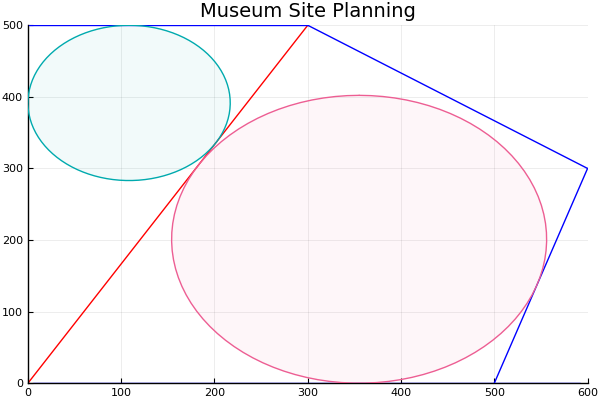

In [28]:
using Plots
pyplot()

x = 0:600
y1 = (5/3)x
y2 = 700 .- (2/3)x
y3 = 500
y4 = 3x .- 1500
plot(x, y1, xlim = (0,600), ylim = (0,500), color = "red", 
    title="Museum Site Planning")
plot!(x, y2,color = "blue")
plot!(zero, color = "blue")
plot!(x, y4,color = "blue")
x = 1:300
plot!(x, y3*ones(size(x)), color = "blue")
tmin = 0
tmax = 2pi
tvec = range(tmin, stop = tmax, length = 100)
plot!(center1[1] .+ radius1*sin.(tvec), center1[2] .+ 
    radius1*cos.(tvec), fill = (0,0.05,:auto))
plot!(center2[1] .+ radius2*sin.(tvec), center2[2] .+ 
    radius2*cos.(tvec), fill = (0,0.05,:auto))
plot!(legend = false)



#b
If the restriction is removed, then the problem is no longer a linear programming problem.
And I think the area that covered by the two new museums without restrictions will be larger than the original area.
Since in a given area, a larger circle can always occupy more areas than the area that two circles can cover. Therefore, if the restriction is removed, and a relatively largest circle is drawn, with the other circle drawn in the remaining area, these two museums would cover more than the original area.